In [36]:
#Data analysis and data cleaning

import pandas as pd
import numpy as np
import random as rnd

def titanic(train,test):
    train_df = pd.read_csv(train)
    test_df = pd.read_csv(test)
    combine = [train_df,test_df]
    
    train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
    test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
    combine = [train_df, test_df]

    for dataset in combine:
        dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

    pd.crosstab(train_df['Title'], train_df['Sex'])

    for dataset in combine:
        dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
        'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

        dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

    train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    for dataset in combine:
        dataset['Title'] = dataset['Title'].map(title_mapping)
        dataset['Title'] = dataset['Title'].fillna(0)

    train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
    test_df = test_df.drop(['Name'], axis=1)
    combine = [train_df, test_df]

    for dataset in combine:
        dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

    guess_ages = np.zeros((2,3))
    guess_ages

    for dataset in combine:
        for i in range(0, 2):
            for j in range(0, 3):
                guess_df = dataset[(dataset['Sex'] == i) & \
                                      (dataset['Pclass'] == j+1)]['Age'].dropna()

                # age_mean = guess_df.mean()
                # age_std = guess_df.std()
                # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

                age_guess = guess_df.median()

                # Convert random age float to nearest .5 age
                guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5

        for i in range(0, 2):
            for j in range(0, 3):
                dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                        'Age'] = guess_ages[i,j]

        dataset['Age'] = dataset['Age'].astype(int)

    for dataset in combine:
        dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1



    for dataset in combine:
        dataset['IsAlone'] = 0
        dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

    combine = [train_df, test_df]

    freq_port = train_df.Embarked.dropna().mode()[0]

    for dataset in combine:
        dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

    test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

    test_df.head(10)
    return train_df, test_df

In [37]:
new_train ,new_test =  titanic('train.csv', 'test.csv')

In [38]:
new_train = pd.get_dummies(new_train)

In [39]:
new_test = pd.get_dummies(new_test)

In [40]:
x = new_train.iloc[:,1:]
y = new_train.iloc[:,0]
x_test = new_test.iloc[:,1:]


In [41]:
#RandomForest
# from sklearn import datasets
# from sklearn import metrics
# from sklearn.ensemble import RandomForestClassifier

# # fit an Extra Trees model to the data
# model = RandomForestClassifier()
# model.fit(x, y)

# # display the relative importance of each attribute
# print(model.feature_importances_)


In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(x, y,
                            test_size=num_test, random_state=23)

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=6, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [43]:
Y_pred = clf.predict(X_test)

In [44]:
from sklearn.metrics import accuracy_score

In [45]:
accuracy_score(y_test,Y_pred)

0.81005586592178769

In [46]:
#hyperParameter Optimization

def hpopt(clf,parameters,x,y):
    acc_scorer = make_scorer(accuracy_score)
    grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
    grid_obj = grid_obj.fit(X_train, y_train)
    return grid_obj
    
    

In [47]:
hpopt(clf,parameters,x,y)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=6, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [1, 5, 8], 'n_estimators': [4, 6, 9], 'min_samples_split': [2, 3, 5], 'criterion': ['entropy', 'gini'], 'max_features': ['log2', 'sqrt', 'auto'], 'max_depth': [2, 3, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(accuracy_score), verbose=0)

In [48]:
import matplotlib.pyplot as plt
def hp_cv_scores(grid_obj):
    grid_obj.cv_results_
    mean_test_scores = grid_obj.cv_results_['mean_test_score']
    mean_train_scores = grid_obj.cv_results_['mean_train_score']
    plt.figure(figsize=(10,6))
#     param_values =[str(x) for x in grid_obj.param_grid.values()[0]]
    param_values = map(str, grid_obj.param_grid.values()[0])
    x = np.arange(1, len(param_values)+1)
    
    plt.plot(x,mean_train_scores,c='r')
    plt.plot(x,mean_test_scores,c='g')
    plt.xlabel(grid_obj.param_grid.keys()[0])
    plt.ylabel('mean scores')
    plt.xticks(x, param_values)
    plt.show()
    
    
#         test_score = grid_obj.cv_results_['mean_test_score']
#     train_score = grid_obj.cv_results_['mean_train_score']
#     labels = map(str, grid_obj.param_grid.values()[0])
#     x = np.arange(1, len(labels)+1)
#     sns.set_style('darkgrid')
#     plt.figure(figsize=(10,6))
#     plt.plot(x, test_score, c='purple')
#     plt.plot(x, train_score, c='green')
#     plt.xlabel(grid_obj.param_grid.keys()[0])
#     plt.xticks(x, labels)
#     plt.show()

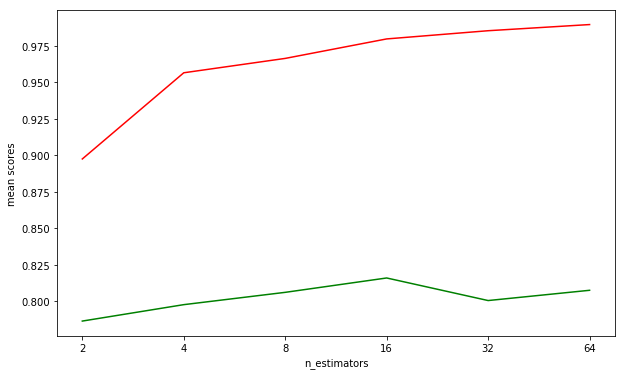

In [49]:
random1 =RandomForestClassifier(oob_score=True)
grid1 = hpopt(random1,{'n_estimators':[2,4,8,16,32,64]},X_train,y_train)
hp_cv_scores(grid1)

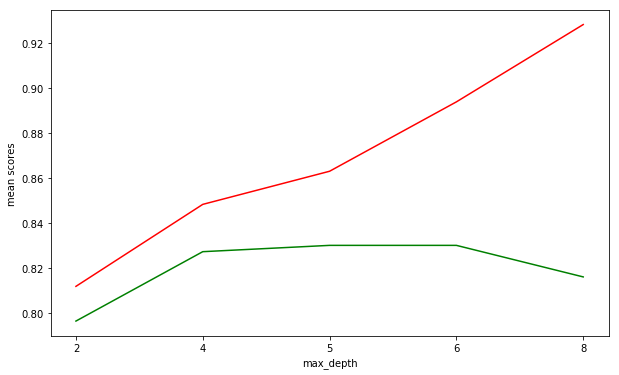

In [50]:
grid2 = hpopt(random1,{'max_depth':[2,4,5,6,8]},X_train,y_train)
hp_cv_scores(grid2)

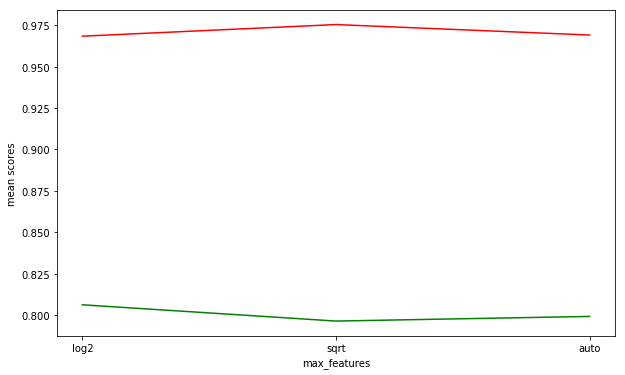

In [51]:
grid3 = hpopt(random1,{'max_features':['log2','sqrt','auto']},X_train,y_train)
hp_cv_scores(grid3)

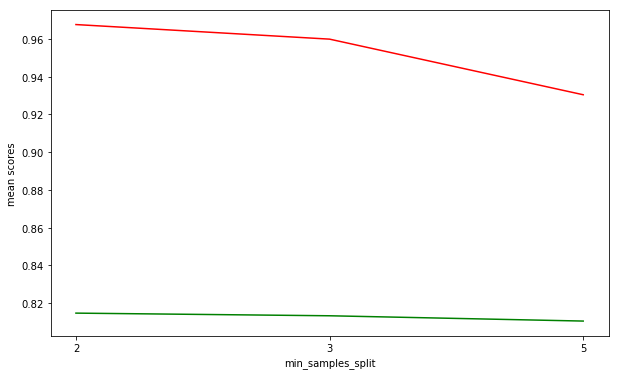

In [52]:
grid4 = hpopt(random1,{'min_samples_split':[2,3,5]},X_train,y_train)
hp_cv_scores(grid4)